# Reassign DecisionTree leaves by $\Delta$IA - Prepare

## Load Balrog-Bagpipes catalog

In [1]:
import pickle

In [2]:
file = '/global/cfs/cdirs/des/elisa/ShearSplits_data/balrog-bagpipes.pkl'
data = pickle.load(open(file, 'rb'), encoding='latin1')
print(f'Length of Balrog-Bagpipes catalog: {len(data)}')

Length of Balrog-Bagpipes catalog: 2417437


In [3]:
data = data.dropna(subset=['stell_best', 'ssfr_best'])
print(f'Length of Balrog-Bagpipes catalog (no nan): {len(data)}')

Length of Balrog-Bagpipes catalog (no nan): 2417396


In [4]:
for i in range(4):
    print(f"Length of Balrog-Bagpipes Bin{i}: {len(data[data['bin']==i])}")

Length of Balrog-Bagpipes Bin0: 613544
Length of Balrog-Bagpipes Bin1: 608122
Length of Balrog-Bagpipes Bin2: 605458
Length of Balrog-Bagpipes Bin3: 590272


## Load DecisionTrees and train/test samples, predictions

In [5]:
import joblib
import pandas as pd

In [6]:
decisiontree_dir = '/global/cfs/cdirs/des/elisa/ShearSplits_data/decisiontree/'
decisiontree_file_template = decisiontree_dir + 'decisiontree_bin{}.joblib'

classifiers = {}

for i in range(4):
    print(f'Loading DecisionTree Bin{i}')
    classifiers[i] = joblib.load(decisiontree_file_template.format(i))

Loading DecisionTree Bin0
Loading DecisionTree Bin1
Loading DecisionTree Bin2
Loading DecisionTree Bin3


/global/homes/e/elegnani/.conda/envs/cosmo_env/lib/python3.11/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [7]:
file = '/global/cfs/cdirs/des/elisa/ShearSplits_data/decisiontree/decisiontree_predictions.pkl'
predictions = pickle.load(open(file, 'rb'), encoding='latin1')
print(f'Length of predictions catalog: {len(predictions)}')

# Add predictions to data
data = pd.merge(data, predictions, on='bal_id', how='inner') # Oss: checked it does it correctly

Length of predictions catalog: 2417396


In [8]:
for i in range(4):
    X_test = data[(data['bin'] == i) & (data['label_pred'] != -1)]
    print(f'Bin{i}')
    print(f"- Number of blue galaxies: {len(X_test[X_test['label_pred']==0])}")
    print(f"- Number of red galaxies:  {len(X_test[X_test['label_pred']==1])}")
    print(f'Number of leaves: {classifiers[i].get_n_leaves()}')
    print()

Bin0
- Number of blue galaxies: 67964
- Number of red galaxies:  54745
Number of leaves: 2910

Bin1
- Number of blue galaxies: 66327
- Number of red galaxies:  55298
Number of leaves: 3145

Bin2
- Number of blue galaxies: 64137
- Number of red galaxies:  56955
Number of leaves: 3072

Bin3
- Number of blue galaxies: 67719
- Number of red galaxies:  50336
Number of leaves: 3091



## Produce table with `leaf_id`, `label`, and properties to compute SNR

In [9]:
import numpy as np
import nz_utils as nz
from split_IA import *

In [10]:
Responses = {}
for i in range(4):
    Responses[i] = np.mean(data[data['bin']==i]['unsheared/R11']+data[data['bin']==i]['unsheared/R22'])/2.
print('Avg response', Responses)

Avg response {0: 0.7475089113672887, 1: 0.7088164619554643, 2: 0.6866178168646271, 3: 0.5944905021663858}


In [11]:
def get_mapping(classifier, X_train, Response):

    # Mapping leaf_id - label
    leaf_ids = np.where(classifier.tree_.children_left == -1)[0]
    leaf_labels = [np.argmax(classifier.tree_.value[leaf][0]) for leaf in leaf_ids]
    leaf_df = pd.DataFrame({
        'leaf_id': leaf_ids,
        'label': leaf_labels
    })
    
    # Save bal_ids of the training sample that fall into each leaf
    flux_columns = ['unsheared/flux_i', 'unsheared/flux_r', 'unsheared/flux_z']
    leaf_assignments = classifier.apply(X_train[flux_columns]) # Re-apply to train dataset
    df_with_leaf = X_train.copy()
    df_with_leaf['leaf_id'] = leaf_assignments
    
    bal_ids = df_with_leaf.groupby('leaf_id')['bal_id'].apply(list)
    leaf_df = leaf_df.merge(bal_ids, on='leaf_id', how='left')

    counts = bal_ids.apply(len).rename('n_train_objects')
    leaf_df = leaf_df.merge(counts, on='leaf_id', how='left')
    
    empty_leaves = leaf_df[leaf_df['bal_id'].isna()]
    if not empty_leaves.empty:
        print('Empty leaves:', empty_leaves['leaf_id'].to_numpy())

    df_with_leaf['sum_w2e2_1'] = (df_with_leaf['unsheared/weight'] ** 2) * ((df_with_leaf['unsheared/e_1'] / Response) ** 2)
    df_with_leaf['sum_w2e2_2'] = (df_with_leaf['unsheared/weight'] ** 2) * ((df_with_leaf['unsheared/e_2'] / Response) ** 2)
    df_with_leaf['sum_w'] = df_with_leaf['unsheared/weight']
    df_with_leaf['sum_w2'] = df_with_leaf['unsheared/weight'] ** 2
    
    df_with_leaf['stell_mean'] = df_with_leaf['stell_best']

    aggregations = {
        'sum_w2e2_1': 'sum',
        'sum_w2e2_2': 'sum',
        'sum_w': 'sum',
        'sum_w2': 'sum',
        'pzc_weighted': 'mean',
        'stell_mean': 'mean',
    }
    
    stats = df_with_leaf.groupby('leaf_id').agg(aggregations).reset_index()
    leaf_df = leaf_df.merge(stats, on='leaf_id', how='left')

    len_pileup = 300
    z3 = np.linspace(0, 2.99, len_pileup)

    pz_per_leaf = df_with_leaf.groupby('leaf_id')['pzc_weighted'].apply(
        lambda x: np.mean(np.stack(x.to_numpy()), axis=0)
    )
    pz_pileup_smooth = pz_per_leaf.apply(lambda pz: nz.pileup_smooth_normalize(pz, z3))
    pz_pileup_smooth_df = pd.DataFrame({
        'leaf_id': pz_pileup_smooth.index,
        'pz_pileup_smooth': pz_pileup_smooth.values
    })

    z_means = pz_pileup_smooth_df['pz_pileup_smooth'].apply(nz.mean_z) # Use median instead?
    pz_pileup_smooth_df['z_mean'] = z_means

    leaf_df = leaf_df.merge(pz_pileup_smooth_df, on='leaf_id', how='left')

    leaf_df['density'] = leaf_df.apply(lambda row: get_density(np.array([row['sum_w']]), np.array([row['sum_w2']])), axis=1)
    leaf_df['shape_noise'] = leaf_df.apply(lambda row: get_shape_noise(np.array([row['sum_w2e2_1']]), np.array([row['sum_w2e2_2']]), np.array([row['sum_w']]), np.array([row['sum_w2']])), axis=1)
    
    return leaf_df

In [12]:
leaf_df = {}
for i in range(4):
    clf = classifiers[i]
    X_train = data[(data['bin'] == i) & (data['label_pred'] == -1)]
    R = Responses[i]

    leaf_df[i] = get_mapping(clf, X_train, R)
    leaf_df[i].to_pickle(f'/global/cfs/cdirs/des/elisa/ShearSplits_data/decisiontree/leaf-label_bin{i}.pkl')

## Produce similar table for predictions

In [13]:
def get_mapping_test(classifier, X_test):

    # Mapping leaf_id - label
    leaf_ids = np.where(classifier.tree_.children_left == -1)[0]
    leaf_labels = [np.argmax(classifier.tree_.value[leaf][0]) for leaf in leaf_ids]
    leaf_df = pd.DataFrame({
        'leaf_id': leaf_ids,
        'label': leaf_labels
    })
    
    # Save bal_ids of the training sample that fall into each leaf
    flux_columns = ['unsheared/flux_i', 'unsheared/flux_r', 'unsheared/flux_z']
    leaf_assignments = classifier.apply(X_test[flux_columns]) # Re-apply to test dataset
    df_with_leaf = X_test.copy()
    df_with_leaf['leaf_id'] = leaf_assignments
    
    bal_ids = df_with_leaf.groupby('leaf_id')['bal_id'].apply(list)
    leaf_df = leaf_df.merge(bal_ids, on='leaf_id', how='left')

    counts = bal_ids.apply(len).rename('n_test_objects')
    leaf_df = leaf_df.merge(counts, on='leaf_id', how='left')

    return leaf_df

In [14]:
leaf_df_test = {}
for i in range(4):
    clf = classifiers[i]
    X_test = data[(data['bin'] == i) & (data['label_pred'] != -1)]

    leaf_df_test[i] = get_mapping_test(clf, X_test)
    leaf_df_test[i].to_pickle(f'/global/cfs/cdirs/des/elisa/ShearSplits_data/decisiontree/leaf-label_test_bin{i}.pkl')

## Load table with `leaf_id`, `label`, and properties to compute SNR

In [1]:
import numpy as np
import pickle
import os
import nz_utils as nz
from split_IA import *
from plot_utils import *

In [2]:
leaf_df = {}
for i in range(4):
    file = f'/global/cfs/cdirs/des/elisa/ShearSplits_data/decisiontree/leaf-label_bin{i}.pkl'
    leaf_df[i] = pickle.load(open(file, 'rb'), encoding='latin1')

## Prepare cosmosis and covariance runs

### Compute fixed cosmological parameters and cov($\Omega_m$, $A_s$) from Planck's chain

In [12]:
from getdist import loadMCSamples, plots
%matplotlib inline

['omegabh2', 'omegach2', 'theta', 'tau', 'logA', 'ns', 'calPlanck', 'amp_143', 'amp_217', 'amp_143x217', 'n_143', 'n_217', 'n_143x217', 'calTE', 'calEE', 'H0', 'omegal', 'omegam', 'omegamh2', 'omegamh3', 'sigma8', 'S8', 's8omegamp5', 's8omegamp25', 's8h5', 'rdragh', 'rmsdeflect', 'zrei', 'A', 'clamp', 'DL40', 'DL220', 'DL810', 'DL1420', 'DL2000', 'ns02', 'yheused', 'YpBBN', 'DHBBN', 'age', 'zstar', 'rstar', 'thetastar', 'DAstar', 'zdrag', 'rdrag', 'kd', 'thetad', 'zeq', 'keq', 'thetaeq', 'thetarseq', 'Hubble015', 'DM015', 'Hubble038', 'DM038', 'Hubble051', 'DM051', 'Hubble061', 'DM061', 'Hubble233', 'DM233', 'fsigma8z015', 'sigma8z015', 'fsigma8z038', 'sigma8z038', 'fsigma8z051', 'sigma8z051', 'fsigma8z061', 'sigma8z061', 'fsigma8z233', 'sigma8z233', 'f2000_143', 'f2000_217', 'f2000_x', 'chi2_lowl', 'chi2_simall', 'chi2_CamSpec', 'chi2_prior', 'chi2_CMB']


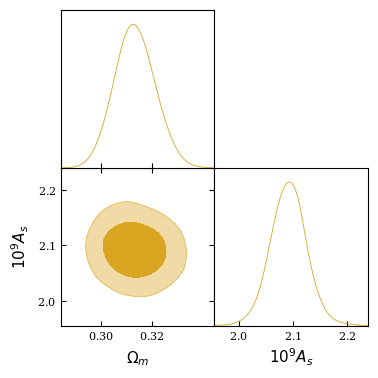

In [13]:
chain = loadMCSamples('cosmosis_runs/planck_chains/base_v12_5HMcln_TTTEEE_lowl_lowE') #from Efstathiou & Gratton 2021 TTTEEE

param_names = chain.getParamNames().list()
params = chain.getParams()

print(param_names)

omega_m = params.omegam
A_s = params.A
tau = params.tau
H0 = params.H0
n_s = params.ns
omega_b_h2 = params.omegabh2
omega_c_h2 = params.omegach2
weights = chain.weights

g = plots.get_subplot_plotter()
g.triangle_plot(chain, ['omegam', 'A'], filled=True, contour_colors=['goldenrod'])

plt.show()

In [14]:
fixed_params = {
    'h0': np.average(H0/100, weights=weights),
    'ombh2': np.average(omega_b_h2, weights=weights),
    'n_s': np.average(n_s, weights=weights),
    'w': -1.0,
    'omega_k': 0.0,
    'tau': np.average(tau, weights=weights),
    'standard_neutrino_neff': 3.044,
    'num_massive_neutrinos': 3,
    'nnu': 3.044,
    'mnu': 0.06,
}

print('fixed cosmological parameters:')
for key, value in fixed_params.items():
    print(f'   {key}: {value:.6f}')

# Deltas and means Omega_m, A_s
delta_params = [0.01, 0.01e-9]
param_names = ['omega_m', 'A_s']
param_means = [np.average(omega_m, weights=weights), np.average(A_s*1e-9, weights=weights)]

def write_cosmo(label, omega_m_val, As_val):
    filename = f'cosmosis_runs/cosmosis_config/values_cosmo_planck{label}.ini'
    print(f'{label} {param_names[0]}: {omega_m_val:.6f}, {param_names[1]}: {As_val:.6e}')
    with open(filename, 'w') as f:
        f.write('%include /global/u1/e/elegnani/ShearSplits/cosmosis_runs/cosmosis_config/values.ini\n')
        f.write('\n')
        f.write('[cosmological_parameters]\n')
        f.write(f"omega_m                =  {omega_m_val:.6f}\n")
        f.write(f"A_s                    =  {As_val:.6e}\n")
        f.write(f"h0                     =  {fixed_params['h0']:.6f}\n")
        f.write(f"ombh2                  =  {fixed_params['ombh2']:.6f}\n")
        f.write(f"n_s                    =  {fixed_params['n_s']:.6f}\n")
        f.write(f"w                      =  {fixed_params['w']}\n")
        f.write(f"omega_k                =  {fixed_params['omega_k']}\n")
        f.write(f"tau                    =  {fixed_params['tau']:.6f}\n")
        f.write('\n')
        f.write(f"standard_neutrino_neff =  {fixed_params['standard_neutrino_neff']:.6f}\n")
        f.write(f"num_massive_neutrinos  =  {fixed_params['num_massive_neutrinos']:.6f}\n")
        f.write(f"nnu                    =  {fixed_params['nnu']:.6f}\n")
        f.write(f"mnu                    =  {fixed_params['mnu']:.6f}\n")

# Central values
write_cosmo('', param_means[0], param_means[1])

# ± delta for omega_m (A_s fixed)
for sign in [-1, 1]:
    om_val = param_means[0] + sign * delta_params[0]
    label = f"_{'+' if sign > 0 else '-'}dOm"
    write_cosmo(label, om_val, param_means[1])

# ± delta for A_s (omega_m fixed)
for sign in [-1, 1]:
    As_val = param_means[1] + sign * delta_params[1]
    label = f"_{'+' if sign > 0 else '-'}dAs"
    write_cosmo(label, param_means[0], As_val)

fixed cosmological parameters:
   h0: 0.674461
   ombh2: 0.022263
   n_s: 0.967141
   w: -1.000000
   omega_k: 0.000000
   tau: 0.053478
   standard_neutrino_neff: 3.044000
   num_massive_neutrinos: 3.000000
   nnu: 3.044000
   mnu: 0.060000
 omega_m: 0.313436, A_s: 2.092086e-09
_-dOm omega_m: 0.303436, A_s: 2.092086e-09
_+dOm omega_m: 0.323436, A_s: 2.092086e-09
_-dAs omega_m: 0.313436, A_s: 2.082086e-09
_+dAs omega_m: 0.313436, A_s: 2.102086e-09


In [15]:
def weighted_cov(x, y, w):
    avg_x = np.average(x, weights=w)
    avg_y = np.average(y, weights=w)
    cov_xy = np.average((x - avg_x) * (y - avg_y), weights=w)
    var_x = np.average((x - avg_x)**2, weights=w)
    var_y = np.average((y - avg_y)**2, weights=w)
    return np.array([[var_x, cov_xy], [cov_xy, var_y]])

cov_Om_As = weighted_cov(omega_m, A_s*1e-9, weights)
# cov_Om_As = np.cov(omega_m, A_s) # Unweighted covariance

print('Covariance matrix between Omega_m and A_s:')
print(cov_Om_As)

Covariance matrix between Omega_m and A_s:
[[ 6.40386260e-05 -2.59987624e-14]
 [-2.59987624e-14  1.15500001e-21]]


In [16]:
np.savez('cosmosis_runs/means_cov_Om_As.npz',
         names =  ['Om', 'As'],
         means = param_means,
         cov = cov_Om_As)

### Save files with n(z)s and mean stellar masses

In [13]:
def prepare_cosmosis_run(leaf_df_i, log_normal_shift, output_dir, label_type='label', print_outputs=False):

    results = {}
    for label in [0, 1]:
        df_label = leaf_df_i[leaf_df_i[label_type] == label]

        pz = np.sum(df_label['pzc_weighted'] * df_label['n_train_objects'], axis=0) / np.sum(df_label['n_train_objects'])
        nz_smooth = nz.pileup_smooth_normalize(pz, z3)

        mean_stell = np.sum(df_label['stell_mean'] * df_label['n_train_objects']) / np.sum(df_label['n_train_objects'])

        results[label] = {
            'nz': nz_smooth,
            'mean_stellar_mass': mean_stell,
            'density': get_density(df_label['sum_w'], df_label['sum_w2']),
            'shape_noise': get_shape_noise(df_label['sum_w2e2_1'], df_label['sum_w2e2_2'], df_label['sum_w'], df_label['sum_w2']),
        }

    # Write n(z) file
    write_nz_file(results[0]['nz'], results[1]['nz'], output_dir)

    # Save mean stellar masses to file
    np.savetxt(f'{output_dir}/stellar_mass_mean.txt', [results[0]['mean_stellar_mass'], results[1]['mean_stellar_mass']], fmt='%.6e')

    # Prepare config file
    with open('cosmosis_runs/covariance/CosmoLike_config_demo.txt', 'rt') as f:
        config = f.read()
        
    config = (config.replace('density1', str(results[0]['density']))
                    .replace('density2', str(results[1]['density']))
                    .replace('shape-noise1', str(results[0]['shape_noise']))
                    .replace('shape-noise2', str(results[1]['shape_noise']))
                    .replace('log-normal-shift-zbin', str(log_normal_shift)))

    with open(f'{output_dir}/CosmoLike_config.txt', 'wt') as f:
        f.write(config)

    if print_outputs == True:
        
        ax.plot(z3, results[0]['nz'], color=matplotlib.colormaps['Blues'](0.5 + i/8))
        ax.plot(z3, results[1]['nz'], color=matplotlib.colormaps['Reds'](0.5 + i/8))

        print(f" - Mean stellar mass blue: {results[0]['mean_stellar_mass']:.2f}")
        print(f" - Mean stellar mass red:  {results[1]['mean_stellar_mass']:.2f}")

        print(f" - Number density blue: {results[0]['density']:.4f}")
        print(f" - Number density red:  {results[1]['density']:.4f}")
    
        print(f" - Shape noise blue: {results[0]['shape_noise']:.3f}")
        print(f" - Shape noise red:  {results[1]['shape_noise']:.3f}\n")
    
    return

Bin0
 - Mean stellar mass blue: 8.99
 - Mean stellar mass red:  9.98
 - Number density blue: 0.0159
 - Number density red:  0.0140
 - Shape noise blue: 0.283
 - Shape noise red:  0.248

Bin1
 - Mean stellar mass blue: 9.27
 - Mean stellar mass red:  10.34
 - Number density blue: 0.0159
 - Number density red:  0.0142
 - Shape noise blue: 0.309
 - Shape noise red:  0.265

Bin2
 - Mean stellar mass blue: 9.74
 - Mean stellar mass red:  10.66
 - Number density blue: 0.0154
 - Number density red:  0.0145
 - Shape noise blue: 0.307
 - Shape noise red:  0.254

Bin3
 - Mean stellar mass blue: 9.69
 - Mean stellar mass red:  10.56
 - Number density blue: 0.0166
 - Number density red:  0.0121
 - Shape noise blue: 0.371
 - Shape noise red:  0.331



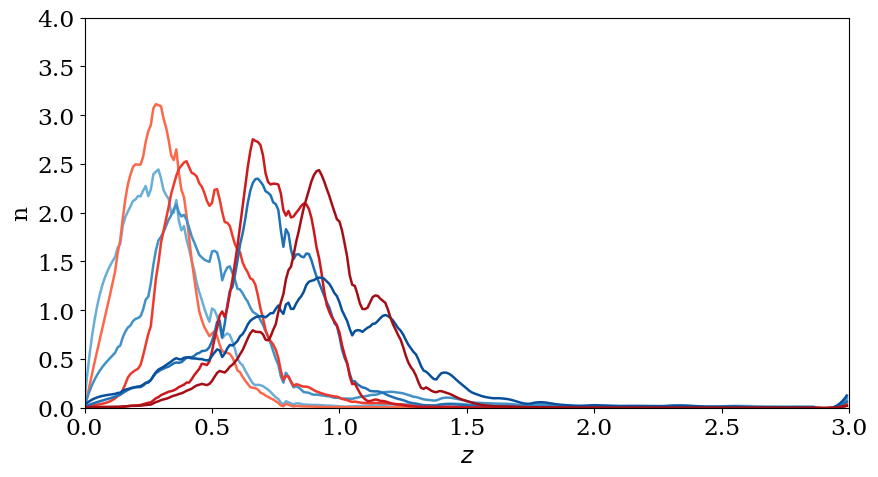

In [14]:
fig = plt.figure(figsize=(9, 5))
ax = fig.gca()

len_pileup = 300
z3 = np.linspace(0, 2.99, len_pileup)

# Original binning
for i in range(4):
    print(f'Bin{i}')
    
    output_dir = f'/global/cfs/cdirs/des/elisa/ShearSplits_data/decisiontree/cosmosis_runs/bin{i}/full'
    os.makedirs(output_dir, exist_ok=True)  # Create the directory if it doesn't exist

    leaf_df_i = leaf_df[i]

    log_normal_shift = get_log_normal_shift(i)
    
    prepare_cosmosis_run(leaf_df_i, log_normal_shift, output_dir, label_type='label', print_outputs=True)

axis_settings(ax, z_params)
ax.set_ylim(0, 4)

plt.tight_layout()
fig.patch.set_alpha(1.0)
plt.show()

In [23]:
# Changed binning by swapping each leaf's label
for i in range(4):
    print(f'Bin{i}')

    # log_normal_shift is the same
    log_normal_shift = get_log_normal_shift(i)
    
    leaf_df_i = leaf_df[i]
    unique_leaf_ids = leaf_df_i['leaf_id'].unique() # Don't need unique() - just a double check

    for leaf_id in unique_leaf_ids:
        if leaf_id % 1000 == 0: print(f'   leaf {leaf_id}') # About 2000 unique leaf_ids, id should go up to 6000

        output_dir = f'/global/cfs/cdirs/des/elisa/ShearSplits_data/decisiontree/cosmosis_runs/bin{i}/leaf_{leaf_id}'
        os.makedirs(output_dir, exist_ok=True)  # Create the directory if it doesn't exist
    
        # Re-make label_temp column in table equal to label
        leaf_df_i['label_temp'] = np.copy(leaf_df_i['label'])

        # Change leaf label in label_temp: swap 0 to 1 and vice versa
        mask = leaf_df_i['leaf_id'] == leaf_id
        leaf_df_i.loc[mask, 'label_temp'] = 1 - leaf_df_i.loc[mask, 'label_temp']
        
        # Assert that label_temp and label columns are different for this leaf
        if (leaf_df_i.loc[mask, 'label_temp'] == leaf_df_i.loc[mask, 'label']).all():
            raise AssertionError(f"Label swap failed for leaf_id {leaf_id} in Bin{i}")
        
        prepare_cosmosis_run(leaf_df_i, log_normal_shift, output_dir, label_type='label_temp', print_outputs=False)

Bin0
   leaf 1000
   leaf 3000
   leaf 5000
Bin1
   leaf 1000
   leaf 4000
   leaf 6000
Bin2
   leaf 1000
   leaf 2000
   leaf 3000
   leaf 6000
Bin3
   leaf 2000
   leaf 4000
   leaf 5000


## Run cosmosis

In [10]:
import subprocess
import shutil
from concurrent.futures import ThreadPoolExecutor
#from tqdm import tqdm

cosmo_labels = ['planck', 'planck_+dOm', 'planck_-dOm', 'planck_+dAs', 'planck_-dAs']

dirs_to_remove = [
    'cmb_cl',
    'cosmological_parameters',
    'distances',
    'fastpt',
    'growth_parameters',
    'intrinsic_alignment_parameters',
    'intrinsic_power',
    'intrinsic_power_bb',
    'intrinsic_power_ee',
    'matter_intrinsic_power',
    'matter_power_lin',
    'matter_power_nl',
    'matter_power_transfer_func',
    'nz_source',
    'recfast',
    'shear_calibration_parameters',
    'shear_cl_bb',
    'shear_cl_eminusb',
    'shear_cl_eplusb',
    'wl_photoz_errors'
]

In [11]:
def run_cosmosis(input_dir, output_dir, cosmo_values):
    
    with open('cosmosis_runs/submit_cosmosis_demo.sh', 'r') as f:
        config = f.read()
        config = config.replace('input_dir', input_dir)
        config = config.replace('output_dir', output_dir)
        config = config.replace('values_cosmo.ini', cosmo_values)
        f.close()

    if os.path.exists(output_dir):
        # Remove everything inside output_dir
        for filename in os.listdir(output_dir):
            file_path = os.path.join(output_dir, filename)
            try:
                if os.path.isfile(file_path) or os.path.islink(file_path):
                    os.unlink(file_path)  # Remove file or link
                elif os.path.isdir(file_path):
                    shutil.rmtree(file_path)  # Remove dir recursively
            except Exception as e:
                print(f'Failed to delete {file_path}. Reason: {e}')
    else:
        os.makedirs(output_dir)

    script_file = f'{output_dir}/submit_cosmosis.sh'
    with open(script_file, 'wt') as f:
        f.write(config)
        f.close()

    # Make it executable
    subprocess.run(['chmod', '+x', script_file])

    # Run the script without printing messages
    subprocess.run(['bash', script_file], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)

    # Remove useless directories
    for sub_dir in dirs_to_remove:
        full_path = os.path.join(output_dir, sub_dir)
        if os.path.isdir(full_path):
            shutil.rmtree(full_path)

In [14]:
# Original binning
for i in range(4):
    for cosmo_label in cosmo_labels:
        print(f'Bin{i}, {cosmo_label} cosmology')

        input_dir = f'/global/cfs/cdirs/des/elisa/ShearSplits_data/decisiontree/cosmosis_runs/bin{i}/full'
        output_dir = f'/global/cfs/cdirs/des/elisa/ShearSplits_data/decisiontree/cosmosis_runs/bin{i}/full/shear_{cosmo_label}'
        cosmo_values = f'values_cosmo_{cosmo_label}.ini'

        run_cosmosis(input_dir, output_dir, cosmo_values)

Bin0, planck cosmology
Bin0, planck_+dOm cosmology
Bin0, planck_-dOm cosmology
Bin0, planck_+dAs cosmology
Bin0, planck_-dAs cosmology
Bin1, planck cosmology
Bin1, planck_+dOm cosmology
Bin1, planck_-dOm cosmology
Bin1, planck_+dAs cosmology
Bin1, planck_-dAs cosmology
Bin2, planck cosmology
Bin2, planck_+dOm cosmology
Bin2, planck_-dOm cosmology
Bin2, planck_+dAs cosmology
Bin2, planck_-dAs cosmology
Bin3, planck cosmology
Bin3, planck_+dOm cosmology
Bin3, planck_-dOm cosmology
Bin3, planck_+dAs cosmology
Bin3, planck_-dAs cosmology


In [ ]:
# Changed binning
def run_cosmosis_leaf(leaf_id, i, cosmo_labels):

    if leaf_id % 1000 == 0: print(f'   leaf {leaf_id}')
    input_dir = f'/global/cfs/cdirs/des/elisa/ShearSplits_data/decisiontree/cosmosis_runs/bin{i}/leaf_{leaf_id}'
    
    for cosmo_label in cosmo_labels:
        
        output_dir = f'/global/cfs/cdirs/des/elisa/ShearSplits_data/decisiontree/cosmosis_runs/bin{i}/leaf_{leaf_id}/shear_{cosmo_label}'
        cosmo_values = f'values_cosmo_{cosmo_label}.ini'

        run_cosmosis(input_dir, output_dir, cosmo_values)
        
for i in range(4):
    print(f'Bin{i}')
    
    leaf_df_i = leaf_df[i]
    unique_leaf_ids = leaf_df_i['leaf_id'].unique()
    
    with ThreadPoolExecutor(max_workers=4) as executor:  
        futures = [executor.submit(run_cosmosis_leaf, leaf_id, i, cosmo_labels) 
                   for leaf_id in unique_leaf_ids]
        #for future in tqdm(as_completed(futures), total=len(futures), desc="Running cosmosis on single leaves"):
        for future in futures:
            future.result()

## Scale IA signal by stellar mass and compute $\Delta$IA

In [3]:
def compute_IA_signal_stell(output_dir, stell_0=10**10, beta=1.13):
    # From Joachimi 2011:
    # M0 = 10**10 * M_sun
    # beta = 1.13

    bin_pairs = [('1', '1'), ('2', '2'), ('2', '1')]

    # Load stellar mass means
    stell_mean_vals = np.loadtxt(f'{output_dir}/../stellar_mass_mean.txt')
    stell_mean = {
        '1': 10**stell_mean_vals[0], # Stellar masses are log_10(M/M_sun)
        '2': 10**stell_mean_vals[1],
    }
    
    cl_ii_dir = f'{output_dir}/shear_cl_ii'
    cl_gi_dir = f'{output_dir}/shear_cl_gi'

    cl_ii_stell_dir = f'{output_dir}/shear_cl_ii_stell'
    cl_gi_stell_dir = f'{output_dir}/shear_cl_gi_stell'

    os.makedirs(cl_ii_stell_dir, exist_ok=True)
    os.makedirs(cl_gi_stell_dir, exist_ok=True)

    for z1, z2 in bin_pairs:
        
        # Load II and GI Cells
        cl_ii = np.loadtxt(f'{cl_ii_dir}/bin_{z1}_{z2}.txt', comments='#', delimiter=',', unpack=False)
        cl_gi = np.loadtxt(f'{cl_gi_dir}/bin_{z1}_{z2}.txt', comments='#', delimiter=',', unpack=False)

        # Apply scaling
        cl_ii_stell = cl_ii * (stell_mean[z1] / stell_0)**beta * (stell_mean[z2] / stell_0)**beta
        cl_gi_stell = cl_gi * (stell_mean[z1] / stell_0)**beta  # if GI is computed with IA from bin 1

        # Save 
        np.savetxt(f'{cl_ii_stell_dir}/bin_{z1}_{z2}.txt', cl_ii_stell)
        np.savetxt(f'{cl_gi_stell_dir}/bin_{z1}_{z2}.txt', cl_gi_stell)


    xi_types = ['plus', 'minus']
    for xi_type in xi_types:
        
        xi_ii_dir = f'{output_dir}/shear_xi_ii_{xi_type}'
        xi_gi_dir = f'{output_dir}/shear_xi_gi_{xi_type}'
    
        xi_ii_stell_dir = f'{output_dir}/shear_xi_ii_stell_{xi_type}'
        xi_gi_stell_dir = f'{output_dir}/shear_xi_gi_stell_{xi_type}'
    
        os.makedirs(xi_ii_stell_dir, exist_ok=True)
        os.makedirs(xi_gi_stell_dir, exist_ok=True)
    
        for z1, z2 in bin_pairs:
            
            # Load II and GI xis
            xi_ii = np.loadtxt(f'{xi_ii_dir}/bin_{z1}_{z2}.txt', comments='#', delimiter=',', unpack=False)
            xi_gi = np.loadtxt(f'{xi_gi_dir}/bin_{z1}_{z2}.txt', comments='#', delimiter=',', unpack=False)
    
            # Apply scaling
            xi_ii_stell = xi_ii * (stell_mean[z1] / stell_0)**beta * (stell_mean[z2] / stell_0)**beta
            xi_gi_stell = xi_gi * (stell_mean[z1] / stell_0)**beta  # if GI is computed with IA from bin 1
    
            # Save 
            np.savetxt(f'{xi_ii_stell_dir}/bin_{z1}_{z2}.txt', xi_ii_stell)
            np.savetxt(f'{xi_gi_stell_dir}/bin_{z1}_{z2}.txt', xi_gi_stell)

    return

In [4]:
def compute_delta_IA(output_dir):

    bin_pairs = [('1', '1'), ('2', '2'), ('2', '1')]
    xi_IA = {}
    
    xi_types = ['plus', 'minus']
    for xi_type in xi_types:
        
        xi_ii_dir = f'{output_dir}/shear_xi_ii_stell_{xi_type}'
        xi_gi_dir = f'{output_dir}/shear_xi_gi_stell_{xi_type}'
    
        for z1, z2 in bin_pairs:
        
            # Load II and GI xis
            xi_ii = np.loadtxt(f'{xi_ii_dir}/bin_{z1}_{z2}.txt', comments='#', delimiter=',', unpack=False)
            xi_gi = np.loadtxt(f'{xi_gi_dir}/bin_{z1}_{z2}.txt', comments='#', delimiter=',', unpack=False)
        
            # Combine to get IA signal
            xi_IA[(xi_type, z1, z2)] = xi_ii + xi_gi

    delta_IA_plus = xi_IA[('plus', '2', '2')] - xi_IA[('plus', '1', '1')] # Red - Blue
    delta_IA_minus = xi_IA[('minus', '2', '2')] - xi_IA[('minus', '1', '1')] # Red - Blue

    delta_IA = np.concatenate([delta_IA_plus, delta_IA_minus])

    # Save
    np.savetxt(f'{output_dir}/delta_IA.txt', delta_IA)

    return

In [19]:
# Original binning
for i in range(4):
    for cosmo_label in cosmo_labels:
        print(f'Bin{i}, {cosmo_label} cosmology')
        output_dir = f'/global/cfs/cdirs/des/elisa/ShearSplits_data/decisiontree/cosmosis_runs/bin{i}/full/shear_{cosmo_label}'
    
        compute_IA_signal_stell(output_dir)
        compute_delta_IA(output_dir)

Bin0, planck cosmology
Bin0, planck_+dOm cosmology
Bin0, planck_-dOm cosmology
Bin0, planck_+dAs cosmology
Bin0, planck_-dAs cosmology
Bin1, planck cosmology
Bin1, planck_+dOm cosmology
Bin1, planck_-dOm cosmology
Bin1, planck_+dAs cosmology
Bin1, planck_-dAs cosmology
Bin2, planck cosmology
Bin2, planck_+dOm cosmology
Bin2, planck_-dOm cosmology
Bin2, planck_+dAs cosmology
Bin2, planck_-dAs cosmology
Bin3, planck cosmology
Bin3, planck_+dOm cosmology
Bin3, planck_-dOm cosmology
Bin3, planck_+dAs cosmology
Bin3, planck_-dAs cosmology


In [ ]:
# Changed binning
for i in range(4):
    print(f'Bin{i}')

    leaf_df_i = leaf_df[i]
    unique_leaf_ids = leaf_df_i['leaf_id'].unique()

    for leaf_id in unique_leaf_ids:
        if leaf_id % 1000 == 0: print(f'   leaf {leaf_id}')
        
        for cosmo_label in cosmo_labels:
            
            output_dir = f'/global/cfs/cdirs/des/elisa/ShearSplits_data/decisiontree/cosmosis_runs/bin{i}/leaf_{leaf_id}/shear_{cosmo_label}'

            compute_IA_signal_stell(output_dir)
            compute_delta_IA(output_dir)

## Compute covariances

In [16]:
def write_cls_for_covariance(output_dir):
    
    cl_ii_dir = f'{output_dir}/shear_planck/shear_cl_ii_stell'
    cl_gi_dir = f'{output_dir}/shear_planck/shear_cl_gi_stell'
    cl_output_dir = f'{output_dir}/shear_planck/Cl_CosmoLike_Y3_Nsource4_lmax50000_zmax10'
    os.makedirs(cl_output_dir, exist_ok=True)

    bin_pairs = [('1', '1'), ('2', '2'), ('2', '1')]

    for z1, z2 in bin_pairs:
        
        # Load II and GI Cells
        cl_ii = np.loadtxt(f'{cl_ii_dir}/bin_{z1}_{z2}.txt', comments='#', delimiter=',', unpack=False)
        cl_gi = np.loadtxt(f'{cl_gi_dir}/bin_{z1}_{z2}.txt', comments='#', delimiter=',', unpack=False)

        # Combine to get IA signal
        cl_IA = cl_ii + cl_gi
        
        # Write to file for covariance
        output_file = f'{cl_output_dir}/Y3_3x2pt_Nsource4-Cl_f2z{z1}_f2z{z2}'
        with open(output_file, 'w') as f:
            for ell, cl_val in enumerate(cl_IA, start=1):
                f.write(f'{ell} {cl_val}\n')

    # Write config file with Cells_list
    with open('cosmosis_runs/covariance/CosmoLike_Cells_list_demo.txt', 'r') as f:
        lines = f.readlines()
    lines_temp = [line.replace('output_dir', f'{output_dir}/shear_planck') for line in lines]
    with open(f'{output_dir}/CosmoLike_Cells_list.txt', 'w') as f:
        f.writelines(lines_temp)

    return

In [17]:
def covariance_delta_IA(output_dir):

    cov = np.load(f'{output_dir}/shear_planck/covariance.npy')

    cov_1 = np.copy(cov[:40, :40])
    cov_1[20:40, 20:40] = np.copy(cov[60:80, 60:80])
    cov_1[:20, 20:40] = np.copy(cov[:20, 60:80])
    cov_1[20:40, :20] = np.copy(cov[60:80, :20])

    cov_2 = np.copy(cov[40:80, 40:80])
    cov_2[20:40, 20:40] = np.copy(cov[100:, 100:])
    cov_2[:20, 20:40] = np.copy(cov[40:60, 100:])
    cov_2[20:40, :20] = np.copy(cov[100:, 40:60])
    
    cov_cross = np.copy(cov[20:60, 20:60])
    cov_cross[20:40, 20:40] = np.copy(cov[80:100, 80:100])
    cov_cross[:20, 20:40] = np.copy(cov[20:40, 80:100])
    cov_cross[20:40, :20] = np.copy(cov[80:100, 20:40])

    # Total covariance of delta_xi
    delta_cov = cov_1 + cov_2 - cov_cross - cov_cross.T

    np.save(f'{output_dir}/covariance_delta_IA.npy', delta_cov)
    
    return

In [18]:
def covariance_cosmo(output_dir):

    params = np.load('cosmosis_runs/means_cov_Om_As.npz')
    delta_params = [0.01, 0.01e-9]
    param_names = params['names']
    param_means = params['means']
    cov_params = params['cov']

    delta_xi =  np.zeros((len(param_names), 40))  
    
    for i in range(len(param_names)):
        file_p = f'{output_dir}/shear_planck_+d{param_names[i]}/delta_IA.txt'
        file_m = f'{output_dir}/shear_planck_-d{param_names[i]}/delta_IA.txt'
        delta_xi_p = np.loadtxt(file_p)
        delta_xi_m = np.loadtxt(file_m)
        
        delta_xi[i] = (delta_xi_p - delta_xi_m) / (2 * delta_params[i])

    cov = delta_xi.T @ cov_params @ delta_xi
    
    np.save(f'{output_dir}/covariance_cosmo.npy', cov)

    return

In [20]:
# Run the script for covariance - Fixed GSL version 2.8 but still does not work --> run from terminal
#
#prefix_path = os.path.expanduser('/global/u1/e/elegnani/gsl-2.8')
#env = os.environ.copy()
#env['PATH'] = f"{prefix_path}/bin:" + env.get('PATH', '')
#env['LD_LIBRARY_PATH'] = f"{prefix_path}/lib:" + env.get('LD_LIBRARY_PATH', '')
#subprocess.run(['gsl-config', '--version'], env=env) --> 2.8

#script_file = 'cosmosis_runs/covariance/run_covariance.py'
#subprocess.run(['chmod', '+x', script_file])

2.8


CompletedProcess(args=['gsl-config', '--version'], returncode=0)

In [22]:
# Original binning
for i in range(4):
    output_dir = f'/global/cfs/cdirs/des/elisa/ShearSplits_data/decisiontree/cosmosis_runs/bin{i}/full'

    covariance_cosmo(output_dir)
    
    write_cls_for_covariance(output_dir)
    
    # Run the script - Fixed GSL version 2.8 but still does not work --> run from terminal
    #subprocess.run(['python3', script_file, output_dir], env=env)

    #covariance_delta_IA(output_dir)

Run covariance in terminal:

```
module load python
conda activate cosmo_env
export LD_LIBRARY_PATH=/global/u1/e/elegnani/gsl-2.8/lib:$LD_LIBRARY_PATH
export PATH=/global/u1/e/elegnani/gsl-2.8/bin:$PATH

python3 run_covariance.py {output_dir}
```

In [25]:
for i in range(4):
    output_dir = f'/global/cfs/cdirs/des/elisa/ShearSplits_data/decisiontree/cosmosis_runs/bin{i}/full'
    covariance_delta_IA(output_dir)

In [ ]:
# Changed binning
def run_covariance_leaf(leaf_id, i):
    if leaf_id % 1000 == 0: print(f'   leaf {leaf_id}')
        
    output_dir = f'/global/cfs/cdirs/des/elisa/ShearSplits_data/decisiontree/cosmosis_runs/bin{i}/leaf_{leaf_id}'

    covariance_cosmo(output_dir)

    write_cls_for_covariance(output_dir)

    # Run the script - Fixed GSL version 2.8 but still does not work --> run from terminal
    #subprocess.run(['python3', script_file, output_dir], env=env)

    #covariance_delta_IA(output_dir)

for i in range(4):
    print(f'Bin{i}')
    
    leaf_df_i = leaf_df[i]
    unique_leaf_ids = leaf_df_i['leaf_id'].unique()

    # Prepare files for running covariance in parallel
    with open(f'cosmosis_runs/covariance/leaf_ids_bin{i}.txt', 'w') as f:
        for leaf_id in unique_leaf_ids:
            f.write(f'{leaf_id}\n')

    with ThreadPoolExecutor(max_workers=4) as executor:  
        futures = [executor.submit(run_covariance_leaf, leaf_id, i) 
                   for leaf_id in unique_leaf_ids]
        for future in futures:
            future.result()

Run covariance(s) in terminal:

```
module load python
conda activate cosmo_env
export LD_LIBRARY_PATH=/global/u1/e/elegnani/gsl-2.8/lib:$LD_LIBRARY_PATH
export PATH=/global/u1/e/elegnani/gsl-2.8/bin:$PATH
 
./run_covariances.sh
```

In [ ]:
# Changed binning
def run_covariance_leaf2(leaf_id, i):
    if leaf_id % 1000 == 0: print(f'   leaf {leaf_id}')
        
    output_dir = f'/global/cfs/cdirs/des/elisa/ShearSplits_data/decisiontree/cosmosis_runs/bin{i}/leaf_{leaf_id}'

    covariance_delta_IA(output_dir)

for i in range(4):
    print(f'Bin{i}')
    
    leaf_df_i = leaf_df[i]
    unique_leaf_ids = leaf_df_i['leaf_id'].unique()

    with ThreadPoolExecutor(max_workers=4) as executor:  
        futures = [executor.submit(run_covariance_leaf2, leaf_id, i) 
                   for leaf_id in unique_leaf_ids]
        for future in futures:
            future.result()

## Add $\Delta$IA, $\Delta$Cov, $\Delta$Cov_cosmo to table

In [23]:
for i in range(4):
    print(f'Bin{i}')

    output_dir = f'/global/cfs/cdirs/des/elisa/ShearSplits_data/decisiontree/cosmosis_runs/bin{i}/full'

    deltaIA = np.loadtxt(f'{output_dir}/shear_planck/delta_IA.txt')
    cov_deltaIA = np.load(f'{output_dir}/covariance_delta_IA.npy')
    cov_cosmo = np.load(f'{output_dir}/covariance_cosmo.npy')
    
    leaf_df_i = leaf_df[i]
    unique_leaf_ids = leaf_df_i['leaf_id'].unique()

    DdeltaIA = {}
    Dcov_deltaIA = {}
    Dcov_cosmo = {}

    for leaf_id in unique_leaf_ids:
        if leaf_id % 1000 == 0: print(f'   leaf {leaf_id}')

        output_dir_leaf = f'/global/cfs/cdirs/des/elisa/ShearSplits_data/decisiontree/cosmosis_runs/bin{i}/leaf_{leaf_id}'

        deltaIA_leaf = np.loadtxt(f'{output_dir_leaf}/shear_planck/delta_IA.txt')
        cov_deltaIA_leaf = np.load(f'{output_dir_leaf}/covariance_delta_IA.npy')
        cov_cosmo_leaf = np.load(f'{output_dir_leaf}/covariance_cosmo.npy')

        DdeltaIA[leaf_id] = deltaIA - deltaIA_leaf
        Dcov_deltaIA[leaf_id] = cov_deltaIA - cov_deltaIA_leaf
        Dcov_cosmo[leaf_id] = cov_cosmo - cov_cosmo_leaf

    leaf_df_i['DdeltaIA'] = leaf_df_i['leaf_id'].map(DdeltaIA)
    leaf_df_i['Dcov_deltaIA'] = leaf_df_i['leaf_id'].map(Dcov_deltaIA)
    leaf_df_i['Dcov_cosmo'] = leaf_df_i['leaf_id'].map(Dcov_cosmo)
    
    cols_to_save = ['leaf_id', 'label', 'DdeltaIA', 'Dcov_deltaIA', 'Dcov_cosmo']
    leaf_df_i[cols_to_save].to_pickle(f'/global/cfs/cdirs/des/elisa/ShearSplits_data/decisiontree/leaf-label_deltas_bin{i}.pkl')

Bin0
   leaf 1000
   leaf 3000
   leaf 5000
Bin1
   leaf 1000
   leaf 4000
   leaf 6000
Bin2
   leaf 1000
   leaf 2000
   leaf 3000
   leaf 6000
Bin3
   leaf 2000
   leaf 4000
   leaf 5000


## Make summary pkl files for shear_cl and shear_xi

In [27]:
dirs_names = [
    'shear_cl', 'shear_cl_gg', 'shear_cl_gi', 'shear_cl_gi_stell', 'shear_cl_ii', 'shear_cl_ii_stell',
    'shear_xi_gi_minus', 'shear_xi_gi_plus', 'shear_xi_gi_stell_minus', 'shear_xi_gi_stell_plus',
    'shear_xi_ii_minus', 'shear_xi_ii_plus', 'shear_xi_ii_stell_minus', 'shear_xi_ii_stell_plus',
    'shear_xi_minus', 'shear_xi_plus'
]

bins = ['bin_1_1', 'bin_2_1', 'bin_2_2']

def write_shear_pickles(output_dir):

    dirs = [f'{output_dir}/{d}' for d in dirs_names]
    dirs_map = {f'{output_dir}/{name}': name for name in dirs_names}
    
    cl_dirs = [d for d in dirs if 'cl' in os.path.basename(d)]
    xi_dirs = [d for d in dirs if 'xi' in os.path.basename(d)]

    def process_measurements(measurement_dirs, data_type):
        result = {b: {} for b in bins}
        sample_dir = measurement_dirs[0]

        # Load ell or theta
        if data_type == 'cl':
            axis_name = 'ell'
            axis_vals = np.loadtxt(f'{sample_dir}/ell.txt')
        else:
            axis_name = 'theta'
            axis_vals = np.loadtxt(f'{sample_dir}/theta.txt')
            theta_edges = np.loadtxt(f'{sample_dir}/theta_edges.txt')

        for b in bins:
            result[b][axis_name] = axis_vals
            if data_type == 'xi':
                result[b]['theta_edges'] = theta_edges

            for d in measurement_dirs:
                fname = f'{d}/{b}.txt'
                if os.path.exists(fname):
                    key = dirs_map[d]  # measurement short name
                    result[b][key] = np.loadtxt(fname)

        return result

    cl_data = process_measurements(cl_dirs, 'cl')
    xi_data = process_measurements(xi_dirs, 'xi')

    with open(f'{output_dir}/shear_cl.pkl', 'wb') as f:
        pickle.dump(cl_data, f)

    with open(f'{output_dir}/shear_xi.pkl', 'wb') as f:
        pickle.dump(xi_data, f)

    # Remove useless directories
    for dname in dirs_names:
        full_path = os.path.join(output_dir, dname)
        if os.path.exists(full_path):
            shutil.rmtree(full_path)

In [ ]:
# Original binning
for i in range(4):
    for cosmo_label in cosmo_labels:
        print(f'Bin{i}, {cosmo_label} cosmology')

        output_dir = f'/global/cfs/cdirs/des/elisa/ShearSplits_data/decisiontree/cosmosis_runs/bin{i}/full/shear_{cosmo_label}'

        write_shear_pickles(output_dir)

In [ ]:
# Changed binning
for i in range(4):
    print(f'Bin{i}')

    leaf_df_i = leaf_df[i]
    unique_leaf_ids = leaf_df_i['leaf_id'].unique()

    for leaf_id in unique_leaf_ids:
        if leaf_id % 1000 == 0: print(f'   leaf {leaf_id}')
        
        for cosmo_label in cosmo_labels:
            
            output_dir = f'/global/cfs/cdirs/des/elisa/ShearSplits_data/decisiontree/cosmosis_runs/bin{i}/leaf_{leaf_id}/shear_{cosmo_label}'

            write_shear_pickles(output_dir)

## Compute SNR

In [1]:
import numpy as np
import pickle

In [2]:
leaf_df = {}
for i in range(4):
    file = f'/global/cfs/cdirs/des/elisa/ShearSplits_data/decisiontree/leaf-label_deltas_bin{i}.pkl'
    leaf_df[i] = pickle.load(open(file, 'rb'), encoding='latin1')

In [3]:
def SNR(signal, cov):
    return np.sqrt(np.dot(np.dot(signal.T, np.linalg.inv(cov)), signal))

In [4]:
for i in range(4):
    print(f'Bin{i}')

    output_dir = f'/global/cfs/cdirs/des/elisa/ShearSplits_data/decisiontree/cosmosis_runs/bin{i}/full'

    deltaIA = np.loadtxt(f'{output_dir}/shear_planck/delta_IA.txt')
    cov_deltaIA = np.load(f'{output_dir}/covariance_delta_IA.npy')
    cov_cosmo = np.load(f'{output_dir}/covariance_cosmo.npy')
    cov = cov_deltaIA + cov_cosmo
    
    leaf_df_i = leaf_df[i]
    leaf_df_i['label_final'] = np.copy(leaf_df_i['label'])
    unique_leaf_ids = leaf_df_i['leaf_id'].unique()

    SNR_original = SNR(deltaIA, cov)
    print('SNR =', SNR_original)
    
    SRN_updated = SNR_original

    for leaf_id in unique_leaf_ids:
        if leaf_id % 1000 == 0: print(f'   leaf {leaf_id}')

        mask = leaf_df_i['leaf_id'] == leaf_id
        DdeltaIA = leaf_df_i.loc[mask, 'DdeltaIA'].values[0]
        Dcov_deltaIA = leaf_df_i.loc[mask, 'Dcov_deltaIA'].values[0]
        Dcov_cosmo = leaf_df_i.loc[mask, 'Dcov_cosmo'].values[0]

        SRN_new = SNR(deltaIA + DdeltaIA, (cov_deltaIA + Dcov_deltaIA) + (cov_cosmo + Dcov_cosmo))

        if SRN_new > SRN_updated:
            print('Changing leaf assignment: leaf_id =', leaf_id, ', SNR =', SRN_new)
            leaf_df_i.loc[mask, 'label_final'] = 1 - leaf_df_i.loc[mask, 'label_final'] # Change final assignment
            SRN_updated = SRN_new

    cols_to_save = ['leaf_id', 'label', 'DdeltaIA', 'Dcov_deltaIA', 'Dcov_cosmo', 'label_final']
    leaf_df_i[cols_to_save].to_pickle(f'/global/cfs/cdirs/des/elisa/ShearSplits_data/decisiontree/leaf-label_deltas_newlabels_bin{i}.pkl')

Bin0
SNR = 0.006907092557371056
Changing leaf assignment: leaf_id = 13 , SNR = 0.006918638829485105
Changing leaf assignment: leaf_id = 16 , SNR = 0.006924147973315973
Changing leaf assignment: leaf_id = 17 , SNR = 0.006924294273401078
Changing leaf assignment: leaf_id = 34 , SNR = 0.006943428307358087
Changing leaf assignment: leaf_id = 43 , SNR = 0.006948727532736286
Changing leaf assignment: leaf_id = 227 , SNR = 0.007036541244039991
Changing leaf assignment: leaf_id = 539 , SNR = 0.00715001897571368
Changing leaf assignment: leaf_id = 889 , SNR = 0.0072344191050752096
Changing leaf assignment: leaf_id = 893 , SNR = 0.007355109430049801
Changing leaf assignment: leaf_id = 920 , SNR = 0.007700637815580702
   leaf 1000
   leaf 3000
   leaf 5000
Bin1
SNR = 0.01014720899241043
Changing leaf assignment: leaf_id = 8 , SNR = 0.01016455406158266
Changing leaf assignment: leaf_id = 17 , SNR = 0.010166829145407038
Changing leaf assignment: leaf_id = 18 , SNR = 0.01017031955335302
Changing lea

In [ ]:
# For a second round, take into account those leaves that have been changed and use -DdeltaIA, -Dcov_deltaIA -Dcov_cosmo ?